In [1]:
import optuna
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn           as sns
import numpy             as np
import pandas            as pd

from sklearn.model_selection         import train_test_split
from sklearn.metrics                 import *
from sklearn.feature_extraction.text import TfidfVectorizer
from mlflow.models.signature         import infer_signature
from sklearn.linear_model            import LogisticRegression
from sklearn.svm                     import SVC
from xgboost                         import XGBClassifier
from lightgbm                        import LGBMClassifier
from sklearn.neighbors               import KNeighborsClassifier
from sklearn.naive_bayes             import MultinomialNB
from sklearn.ensemble                import RandomForestClassifier
from sklearn.ensemble                import StackingClassifier
from imblearn.over_sampling          import SMOTE

In [2]:
df = pd.read_csv('preprocessed_corpus.csv')
df.head()

,raw_comment,category,word_count_raw,char_count_raw,num_unique_words,num_upper_words,num_punctuation_raw,cleaned_comment,num_stop_words,processed_comment,final_word_count,final_char_count
0,family mormon have never tried explain them t...,1,39,261,34,0,0,family mormon have never tried explain them th...,13,family mormon never tried explain still stare ...,26,171
1,buddhism has very much lot compatible with chr...,1,196,1269,136,0,0,buddhism has very much lot compatible with chr...,56,buddhism much lot compatible christianity espe...,140,842
2,seriously don say thing first all they won get...,-1,86,460,67,0,0,seriously don say thing first all they won get...,40,seriously say thing first get complex explain ...,46,230
3,what you have learned yours and only yours wha...,0,29,168,24,0,0,what you have learned yours and only yours wha...,14,learned want teach different focus goal not wr...,15,87
4,for your own benefit you may want read living ...,1,112,691,82,0,0,for your own benefit you may want read living ...,46,benefit may want read living buddha living chr...,66,397


In [3]:
# Step 2: Set up the MLflow tracking server
mlflow.set_tracking_uri("http://ec2-13-201-96-130.ap-south-1.compute.amazonaws.com:5000/")

In [4]:
# # create an experiment 
# mlflow.create_experiment(
#                             name              = "Experiment_8_stacking",
#                             artifact_location = "s3://mlflow-s3-25/Experiment_8_stacking"
#                         )

In [5]:
# set an experiment
mlflow.set_experiment("Experiment_8_stacking")

<Experiment: artifact_location='s3://mlflow-s3-25/Experiment_8_stacking', creation_time=1757001997592, experiment_id='703058603283021543', last_update_time=1757001997592, lifecycle_stage='active', name='Experiment_8_stacking', tags={}>

In [6]:
# Step 1: Remap the class labels from [-1, 0, 1] to [2, 0, 1]
df['category']       = df['category'].map({-1: 2, 0: 0, 1: 1})

# Step 4: Train-test split before vectorization and resampling
X_train, X_test, y_train, y_test = train_test_split(df['processed_comment'], df['category'], test_size=0.2, random_state=42, stratify=df['category'])

# Step 2: Vectorization using TF-IDF, fit on training data only
ngram_range          = (1, 3)                                    # Trigram setting
max_features         = 10000                                     # Set max_features to 1000 for TF-IDF

vectorizer           = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
X_train_vec          = vectorizer.fit_transform(X_train)          # Fit on training data
X_test_vec           = vectorizer.transform    (X_test)           # Transform test data

smote                = SMOTE(random_state=42)
X_train_vec, y_train = smote.fit_resample(X_train_vec, y_train)

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [7]:
# Step 4: Define base learners
lightgbm_model    = LGBMClassifier(
                                        objective     = 'multiclass',
                                        num_class     = 3,
                                        metric        = 'multi_logloss',
                                        is_unbalance  = True,
                                        class_weight  = 'balanced',
                                        reg_alpha     = 0.1,
                                        reg_lambda    = 0.1,
                                        learning_rate = 0.08081298097796712,
                                        n_estimators  = 367,
                                        max_depth     = 20,
                                        random_state  = 42
                                     )

logreg_model     = LogisticRegression(
                                        max_iter      = 1000,
                                        class_weight  = 'balanced',
                                        solver        = 'lbfgs',
                                        multi_class   = 'multinomial',
                                        random_state  = 42
                                     )

knn_meta_learner = KNeighborsClassifier(n_neighbors=5)


In [8]:
# Step 5: Build stacking model
stacking_model = StackingClassifier(
                                        estimators      = [
                                                            ('lightgbm',            lightgbm_model),
                                                            ('logistic_regression', logreg_model)
                                                          ],
                                        final_estimator = knn_meta_learner,
                                        cv              = 5,
                                        n_jobs          = -1
                                     )

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does n

C:\Users\venka\anaconda3\envs\DL_TF_GPU_MLFlow_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Evaluation Metrics : Stacking_LGBM_LogReg_KNN_model : (values close to 1 represent the GOOD Model)

	Accuracy     : 0.84    --> [TP + TN]/ALL       : The proportion of correctly predicted observations over total predictions
	Log Loss     : 2.65    --> Measures the performance of a classification model, Less is Good
	Macro  		       --> Macro average       : Treats all classes equally by computing the unweighted mean of per-class metrics
	  Precision  : 0.83    --> [TP]     /[TP + FP] : The proportion of true positive predictions over total positive predictions 
	  Recall     : 0.83    --> [TP]     /[TP + FN] : The proportion of true positive predictions over total actual positives.
	  F1-Score   : 0.83    --> The harmonic mean of precision and recall, useful when FP and FN both have serious consequences
	  ROC-AUC    : 0.92    --> Measures the ability of the model to distinguish between classes.
	Weighted  	       --> Weighted average    : Accounts for class imbalance by weighting each

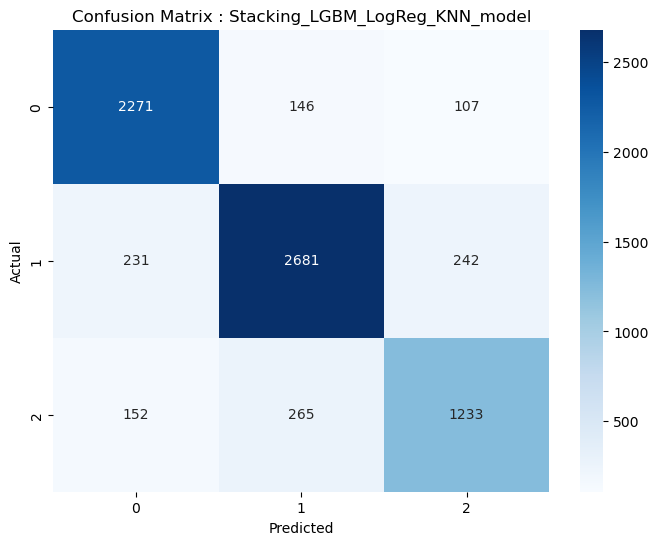

In [9]:
# Step 6: Train and log with MLflow
with mlflow.start_run():
    mlflow.set_tag("mlflow.runName",  "Stacking_LGBM_LogReg_KNN")
    mlflow.set_tag("experiment_type", "stacking_ensemble")
    mlflow.set_tag("model_type",      "StackingClassifier")
    mlflow.set_tag("description",     "Stacked model with TF-IDF (Trigrams, 10k), LightGBM + Logistic Regression base learners, KNN meta-learner")

    # Log vectorizer params
    mlflow.log_param("vectorizer_type", "TfidfVectorizer")
    mlflow.log_param("vectorizer_max_features", vectorizer.max_features)

    # Log model params
    mlflow.log_param("base_1",       "LightGBM")
    mlflow.log_param("base_2",       "LogisticRegression")
    mlflow.log_param("meta_learner", "KNeighborsClassifier")
    mlflow.log_param("cv", 5)

    # Train model
    stacking_model.fit(X_train_vec, y_train)
    y_pred             = stacking_model.predict(X_test_vec)

    # Step 5: Compute Evaluation Metrics
    accuracy           = accuracy_score       (y_test, y_pred)
    
    macro_precision    = precision_score      (y_test, y_pred, average='macro')
    macro_recall       = recall_score         (y_test, y_pred, average='macro')            # Recall or Sensitivity
    macro_F1_score     = f1_score             (y_test, y_pred, average='macro')
    macro_roc_auc      = roc_auc_score        (y_test, stacking_model.predict_proba(X_test_vec), average='macro', multi_class='ovr')
    weighted_precision = precision_score      (y_test, y_pred, average='weighted')
    weighted_recall    = recall_score         (y_test, y_pred, average='weighted')         # Recall or Sensitivity
    weighted_F1_score  = f1_score             (y_test, y_pred, average='weighted')
    weighted_roc_auc   = roc_auc_score        (y_test, stacking_model.predict_proba(X_test_vec), average='weighted', multi_class='ovr')
    
    log_loss_value     = log_loss             (y_test, stacking_model.predict_proba(X_test_vec))
    cm                 = confusion_matrix     (y_test, y_pred)
    cr                 = classification_report(y_test, y_pred)
    
    # Step 7: Log Class-wise Metrics from Classification Report
    classification_rep = classification_report(y_test, y_pred, output_dict=True)

    for label, metrics in classification_rep.items():
        clean_label    = label.replace(" avg", "")                   # Remove " avg" from label if present
        if isinstance(metrics, dict):
            for metric, value in metrics.items():
                mlflow.log_metric(f"{clean_label}_{metric}", value)  
        else:
            mlflow.log_metric(f"{clean_label}", metrics)             # Logs accuracy metric
    
    # Step 6: Log Remaining Metrics to MLflow
    mlflow.log_metric("log_loss",         log_loss_value)        
    mlflow.log_metric("macro_roc_auc",    macro_roc_auc)
    mlflow.log_metric("weighted_roc_auc", weighted_roc_auc)
    
    # Step 8: Plot and Log Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix : Stacking_LGBM_LogReg_KNN_model")
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # Step 9: saving and logging the dataset
    df.to_csv("dataset.csv", index=False)
    mlflow.log_artifact("dataset.csv")
    
    # Step 10: Log Model and Dataset
    input_example = X_test_vec[:5]                                           # input_example provides a sample input for the model, 
                                                                             # useful for UI display and validation
    signature     = infer_signature(X_train_vec, stacking_model.predict(X_train_vec)) # signature defines the expected input/output schema of the model, 
                                                                             # enabling reproducibility and serving
    
    mlflow.sklearn.log_model(
                                sk_model      = stacking_model,
                                name          = "Stacking_LGBM_LogReg_KNN_model",
                                input_example = input_example,
                                signature     = signature
                            ) 

    # Step 11: Print Evaluation Summary
    print(f"\033[1m\033[4mEvaluation Metrics : Stacking_LGBM_LogReg_KNN_model\033[0m : (values close to 1 represent the GOOD Model)\n")
    print(f'\tAccuracy     : {accuracy:.2f}    --> [TP + TN]/ALL       : The proportion of correctly predicted observations over total predictions')
    print(f'\tLog Loss     : {log_loss_value:.2f}    --> Measures the performance of a classification model, Less is Good')
    print(f'\t\033[1m\033[4mMacro\033[0m  \t\t       --> Macro average       : Treats all classes equally by computing the unweighted mean of per-class metrics')
    print(f'\t  Precision  : {macro_precision:.2f}    --> [TP]     /[TP + FP] : The proportion of true positive predictions over total positive predictions ')
    print(f'\t  Recall     : {macro_recall:.2f}    --> [TP]     /[TP + FN] : The proportion of true positive predictions over total actual positives.')
    print(f'\t  F1-Score   : {macro_F1_score:.2f}    --> The harmonic mean of precision and recall, useful when FP and FN both have serious consequences')
    print(f'\t  ROC-AUC    : {macro_roc_auc:.2f}    --> Measures the ability of the model to distinguish between classes.')
    
    print(f'\t\033[1m\033[4mWeighted\033[0m  \t       --> Weighted average    : Accounts for class imbalance by weighting each class metric by its support')
    print(f'\t  Precision  : {weighted_precision:.2f}    --> [TP]     /[TP + FP] : The proportion of true positive predictions over total positive predictions ')
    print(f'\t  Recall     : {weighted_recall:.2f}    --> [TP]     /[TP + FN] : The proportion of true positive predictions over total actual positives.')
    print(f'\t  F1-Score   : {weighted_F1_score:.2f}    --> The harmonic mean of precision and recall, useful when FP and FN both have serious consequences')
    print(f'\t  ROC-AUC    : {weighted_roc_auc:.2f}    --> Measures the ability of the model to distinguish between classes.')
    
    
    print(f'\nConfusion Matix      :         -->    \033[1m\033[4mORIGINAL\033[0m     \t\t\033[1m\033[4mSTANDARD\033[0m\n')
    def format_row(row):
        formatted = ' '.join(f"{val:>2}" for val in row)
        return f"[{formatted}]"
    
    for row1, row2 in zip(cm, np.flip(cm)):
        print("\t\t\t\t  ", format_row(row1), "\t       ", format_row(row2))
    
    print("\nClassification Rpt   :")
    print('\n'.join('\t\t\t\t' + line for line in cr.splitlines()))